<a href="https://colab.research.google.com/github/raju1207/CarDekho-Data-Prediction/blob/main/Car_Resale_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Importing required libraries

import pandas as pd
import json
import os
import numpy as np

In [3]:
# Define Safe JSON Parsers
# Safely load JSON from strings or return as-is if already a dict

def safe_json_load(data):
    if isinstance(data, dict):
        return data
    elif isinstance(data, str):
        try:
            data = data.replace("'", '"').replace("None", "null")
            return json.loads(data)
        except Exception:
            return {}
    return {}

In [4]:
#Define Parsing Functions for Each Column

#Car detail is usually already a dict, or a stringified dict
def parse_car_detail(detail):
    return safe_json_load(detail)

#Overview is a nested dict with 'top' list of specs
def parse_car_overview(overview):
    overview_dict = safe_json_load(overview)
    return {item['key']: item['value'] for item in overview_dict.get('top', [])}

#Feature is a nested structure with 'top' and 'data' sections
def parse_car_features(feature):
    feature_dict = safe_json_load(feature)
    features = {}

    for item in feature_dict.get('top', []):
        features[item['value']] = True

    for section in feature_dict.get('data', []):
        for item in section.get('list', []):
            features[item['value']] = True

    return features

#Car specs are also nested with top-level and detailed sections
def parse_car_specs(spec):
    spec_dict = safe_json_load(spec)
    specs = {}

    for item in spec_dict.get('top', []):
        specs[item['key']] = item['value']

    for section in spec_dict.get('data', []):
        for item in section.get('list', []):
            specs[item['key']] = item['value']

    return specs

In [5]:
#Ensure Column Names Are Unique

#Prevent errors while merging by making columns unique
def make_columns_unique(df):
    cols = pd.Series(df.columns)
    for dup in cols[cols.duplicated()].unique():
        dup_idx = cols[cols == dup].index.tolist()
        for i, idx in enumerate(dup_idx):
            if i > 0:
                cols[idx] = f"{dup}_{i}"
    df.columns = cols
    return df

In [6]:
#Process one city at a time using its Excel file and name

def process_city_file(file_path, city_name):
    df = pd.read_excel(file_path)

    df['new_car_detail'] = df['new_car_detail'].apply(parse_car_detail)
    df_detail = pd.DataFrame(df['new_car_detail'].tolist())

    df['new_car_overview'] = df['new_car_overview'].apply(parse_car_overview)
    df_overview = pd.DataFrame(df['new_car_overview'].tolist())

    df['feature_dict'] = df['new_car_feature'].apply(parse_car_features)
    df_features = (
        pd.json_normalize(df['feature_dict'])
        .fillna(False)
        .infer_objects(copy=False)
        .astype(bool)
        .astype(int)
    )

    df['new_car_specs'] = df['new_car_specs'].apply(parse_car_specs)
    df_specs = pd.DataFrame(df['new_car_specs'].tolist())

    # Combine all data for this city
    combined = pd.concat([df_detail, df_overview, df_features, df_specs], axis=1)
    combined["city"] = city_name
    combined = make_columns_unique(combined)

    # Save as CSV
    csv_name = f"{city_name}_Data.csv"
    combined.to_csv(csv_name, index=False)
    print(f"✅ Saved: {csv_name}")
    return combined

In [7]:
# List of city Excel files

city_files = {
    "Kolkata": "kolkata_cars.xlsx",
    "Jaipur": "jaipur_cars.xlsx",
    "Delhi": "delhi_cars.xlsx",
    "Chennai": "chennai_cars.xlsx",
    "Bangalore": "bangalore_cars.xlsx",
    "Hyderabad": "hyderabad_cars.xlsx",
}

In [8]:
#Loop through all cities and process them
all_data = []

for city, file in city_files.items():
    if os.path.exists(file):
        city_df = process_city_file(file, city)
        all_data.append(city_df)
    else:
        print(f"⚠️ File not found: {file}")

/tmp/ipython-input-6-4236558216.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(False)


✅ Saved: Kolkata_Data.csv


/tmp/ipython-input-6-4236558216.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(False)


✅ Saved: Jaipur_Data.csv


/tmp/ipython-input-6-4236558216.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(False)


✅ Saved: Delhi_Data.csv


/tmp/ipython-input-6-4236558216.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(False)


✅ Saved: Chennai_Data.csv


/tmp/ipython-input-6-4236558216.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(False)


✅ Saved: Bangalore_Data.csv
✅ Saved: Hyderabad_Data.csv


/tmp/ipython-input-6-4236558216.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(False)


In [9]:
#Merge All Cities into One CSV

#Combine all city DataFrames into one
final_df = pd.concat(all_data, ignore_index=True)
final_df = make_columns_unique(final_df)

# Save full dataset
final_df.to_csv("All_Cities_Car_Data.csv", index=False)
print("🎉 Merged and saved as: All_Cities_Car_Data.csv")

🎉 Merged and saved as: All_Cities_Car_Data.csv


In [10]:
#Create ML DataFrame

# Select required columns for ML
list_column = [
    "city", "ft", "bt", "km", "transmission", "ownerNo", "oem", "model",
    "modelYear", "variantName", "price", "Registration Year", "Insurance Validity","Seats", "Engine Displacement"]

ml_df = final_df[list_column].copy()
ml_df = ml_df.loc[:, ~ml_df.columns.duplicated(keep='last')] # Remove duplicates
ml_df.to_excel('ml_dl.xlsx', index=False)
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8369 entries, 0 to 8368
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   city                 8369 non-null   object
 1   ft                   8369 non-null   object
 2   bt                   8369 non-null   object
 3   km                   8369 non-null   object
 4   transmission         8369 non-null   object
 5   ownerNo              8369 non-null   int64 
 6   oem                  8369 non-null   object
 7   model                8369 non-null   object
 8   modelYear            8369 non-null   int64 
 9   variantName          8369 non-null   object
 10  price                8369 non-null   object
 11  Registration Year    8317 non-null   object
 12  Insurance Validity   8365 non-null   object
 13  Seats                8363 non-null   object
 14  Engine Displacement  8365 non-null   object
dtypes: int64(2), object(13)
memory usage: 980.9+ KB



📊 Summary Statistics:
         city      ft         bt        km transmission      ownerNo     oem  \
count    8369    8369       8369      8369         8369  8369.000000    8369   
unique      6       5         11      4090            2          NaN      33   
top     Delhi  Petrol  Hatchback  1,20,000       Manual          NaN  Maruti   
freq     1485    5554       3567       315         6052          NaN    2252   
mean      NaN     NaN        NaN       NaN          NaN     1.360139     NaN   
std       NaN     NaN        NaN       NaN          NaN     0.641958     NaN   
min       NaN     NaN        NaN       NaN          NaN     0.000000     NaN   
25%       NaN     NaN        NaN       NaN          NaN     1.000000     NaN   
50%       NaN     NaN        NaN       NaN          NaN     1.000000     NaN   
75%       NaN     NaN        NaN       NaN          NaN     2.000000     NaN   
max       NaN     NaN        NaN       NaN          NaN     5.000000     NaN   

             mod

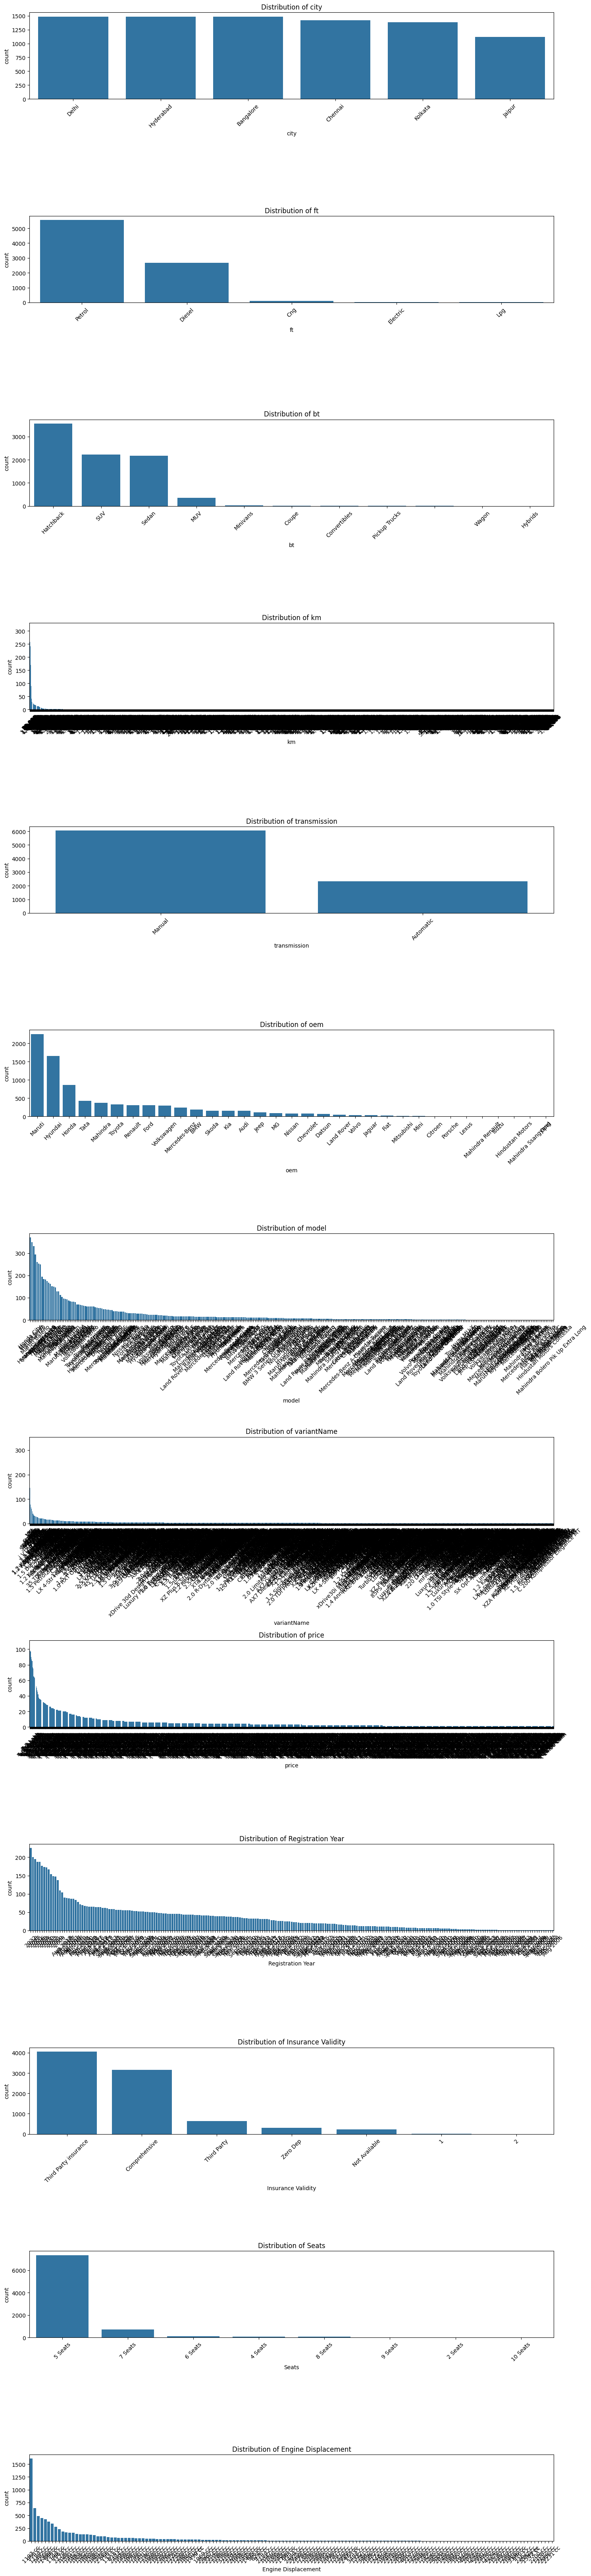

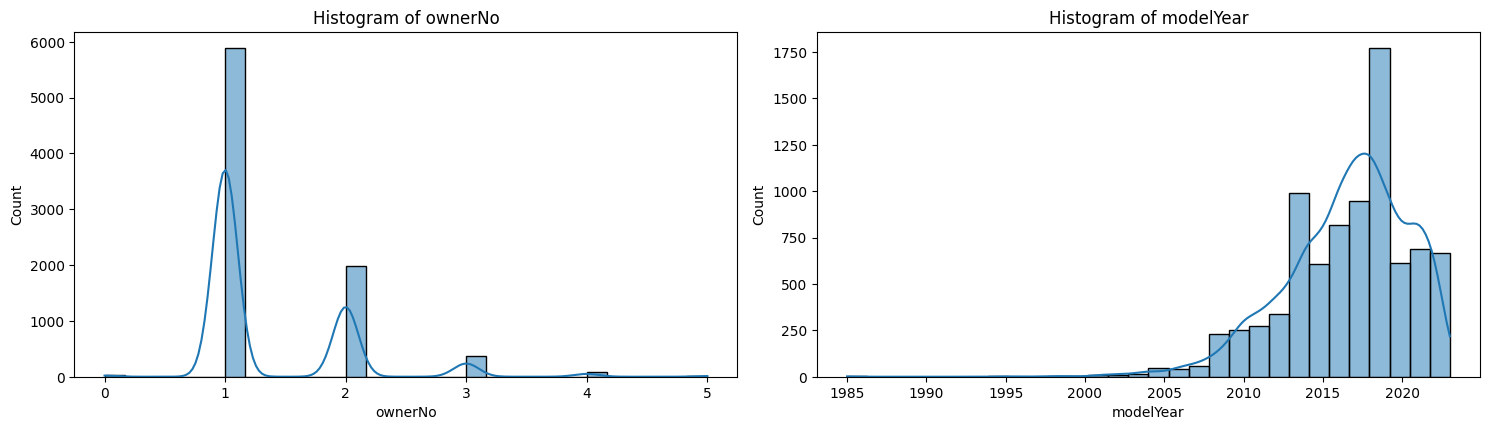

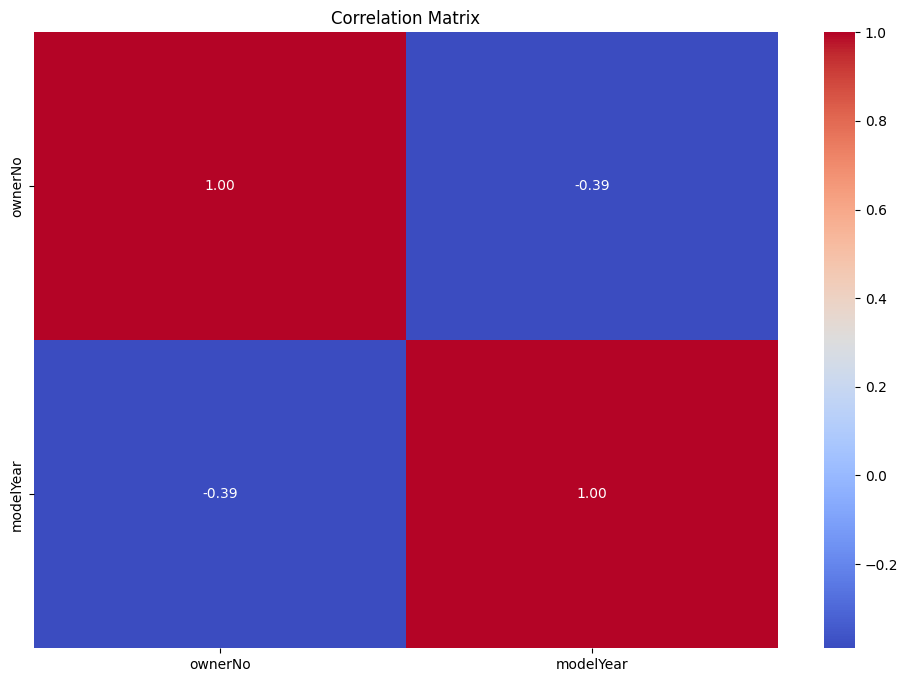

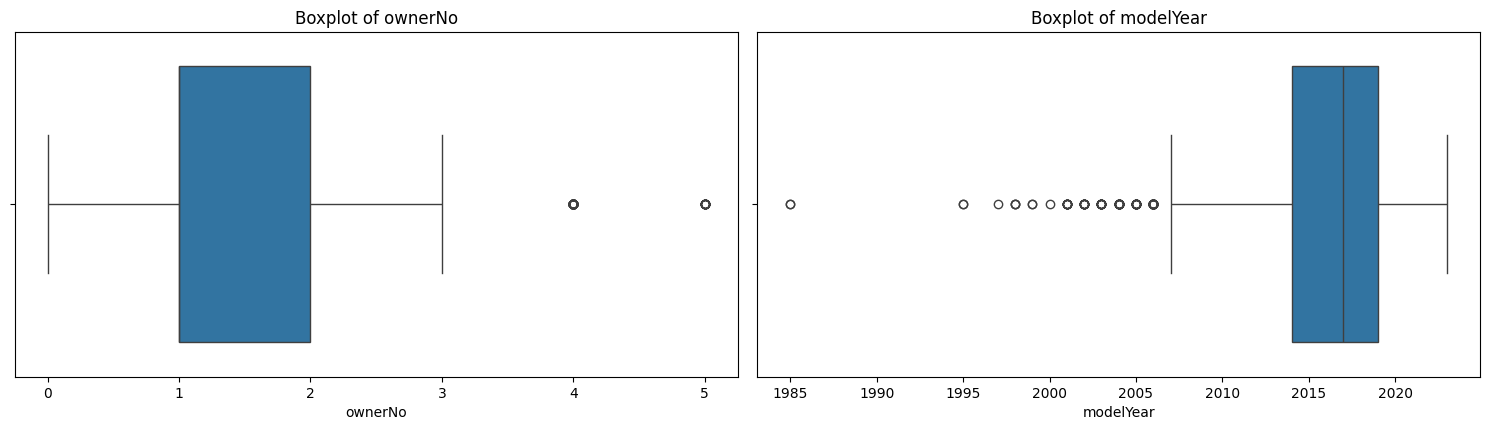

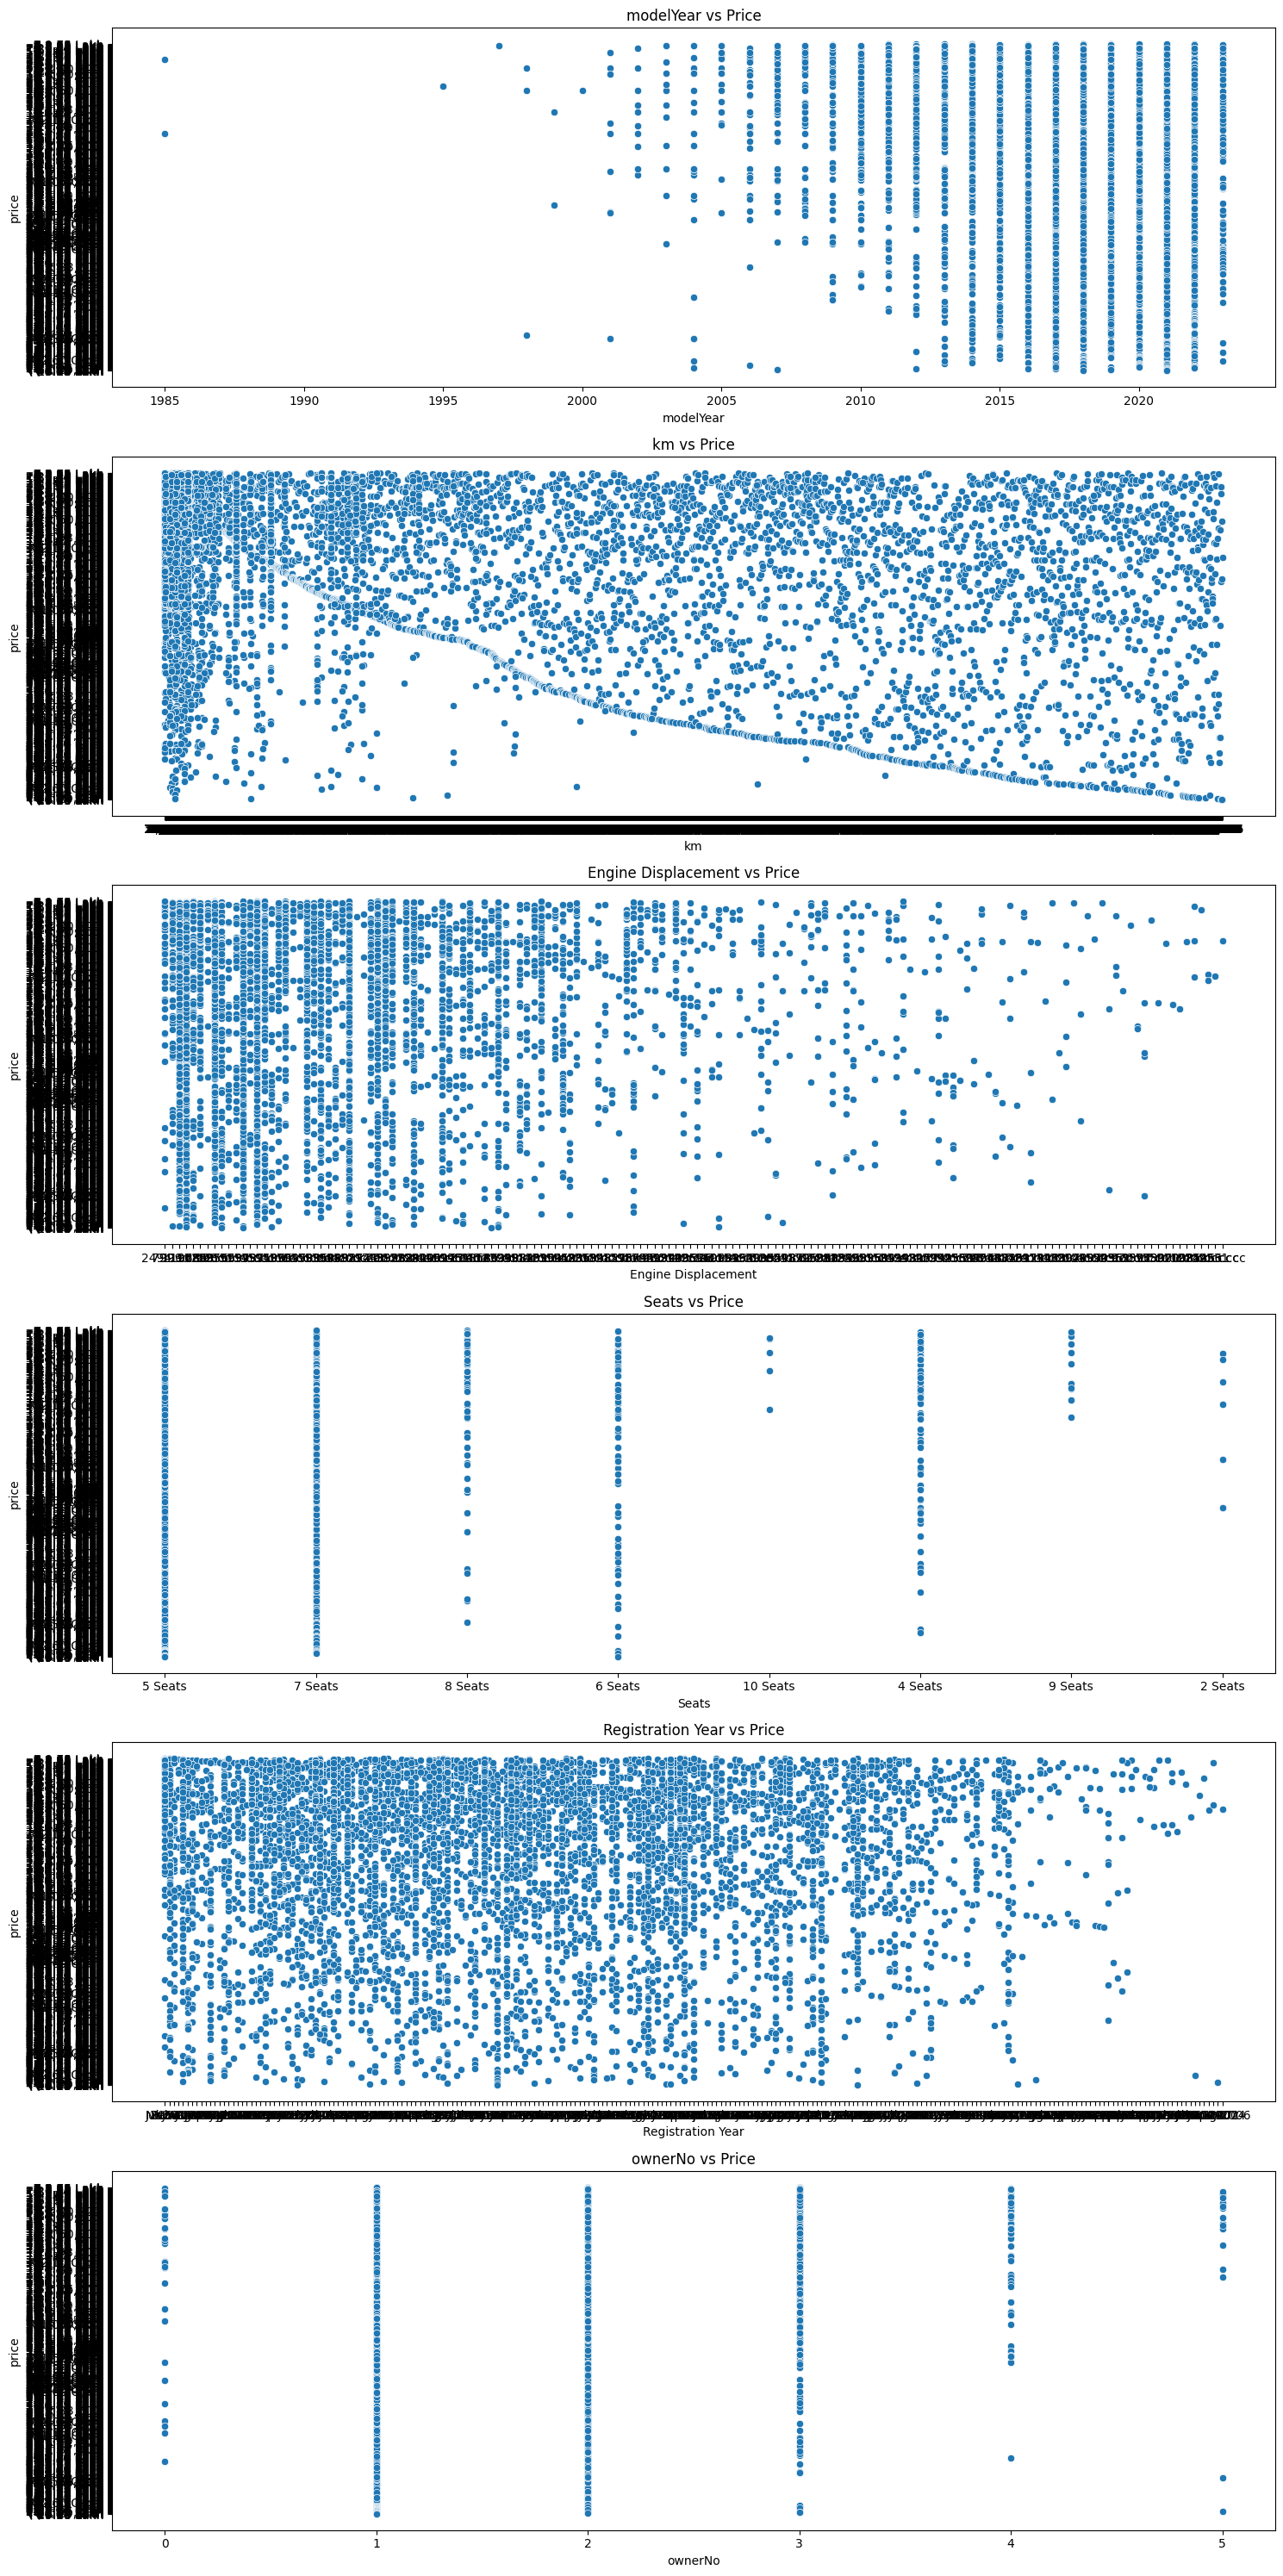

In [11]:
# EDA & VISUALIZATION

import matplotlib.pyplot as plt
import seaborn as sns

# Render plots inline if using Jupyter
# matplotlib inline

# 1. Summary Statistics
print("\n📊 Summary Statistics:")
print(ml_df.describe(include='all'))

# 2. Check Missing Values
print("\n❓ Missing Values:")
print(ml_df.isnull().sum())

# 3. Categorical Column Distribution
categorical_cols = ml_df.select_dtypes(include='object').columns.tolist()

plt.figure(figsize=(15, 5 * len(categorical_cols)))
for i, col in enumerate(categorical_cols):
    plt.subplot(len(categorical_cols), 1, i + 1)
    sns.countplot(data=ml_df, x=col, order=ml_df[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Numerical Column Distribution
numeric_cols = ml_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

plt.figure(figsize=(15, 4 * len(numeric_cols)))
for i, col in enumerate(numeric_cols):
    plt.subplot(len(numeric_cols), 2, i + 1)
    sns.histplot(ml_df[col], kde=True, bins=30)
    plt.title(f"Histogram of {col}")
plt.tight_layout()
plt.show()

# 5. Correlation Heatmap
plt.figure(figsize=(12, 8))
numeric_df = ml_df.select_dtypes(include=[np.number])  # 🔧 Fix: numeric-only
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# 6. Boxplots for Outlier Detection
plt.figure(figsize=(15, 4 * len(numeric_cols)))
for i, col in enumerate(numeric_cols):
    plt.subplot(len(numeric_cols), 2, i + 1)
    sns.boxplot(x=ml_df[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

# 7. Price vs Key Features (Pattern detection)
selected_features = ["modelYear", "km", "Engine Displacement", "Seats", "Registration Year", "ownerNo"]
plt.figure(figsize=(15, 5 * len(selected_features)))
for i, col in enumerate(selected_features):
    plt.subplot(len(selected_features), 1, i + 1)
    sns.scatterplot(data=ml_df, x=col, y="price")
    plt.title(f"{col} vs Price")
plt.tight_layout()
plt.show()


In [12]:
# Clean and transform data
ml_df["km"] = ml_df["km"].astype(str).str.replace(',', '').astype(int)
ml_df["ownerNo"] = ml_df["ownerNo"].astype(int)
ml_df["modelYear"] = ml_df["modelYear"].astype(int)

ml_df["Seats"] = ml_df.apply(
    lambda i: 5 if pd.isna(i["Seats"]) and i["bt"] in ("Hatchback", "Sedan", "SUV") else i["Seats"],
    axis=1
)

ml_df["Seats"] = ml_df["Seats"].astype(str).str.extract(r"(\d+)")
ml_df["Seats"] = ml_df["Seats"].fillna(5).replace("null", 5)
ml_df["Seats"] = ml_df["Seats"].astype(int)

ml_df["Engine Displacement"] = (
    ml_df["Engine Displacement"]
    .fillna(0)
    .astype(str)
    .str.replace(" cc", "")
    .replace("", "0")
    .astype(int)
)

ml_df["Registration Year"] = ml_df["Registration Year"].str.replace(r'\D+', '', regex=True)
ml_df["Registration Year"] = ml_df.apply(
    lambda i: i["modelYear"] if pd.isna(i["Registration Year"]) or i["Registration Year"] == "" else i["Registration Year"],
    axis=1
)
ml_df["Registration Year"] = ml_df["Registration Year"].astype(int)

ml_df["price"] = ml_df["price"].str.replace(',', '')

def convert_to_integer(value):
    value = value.replace('₹', '').strip()
    if 'Crore' in value:
        return int(float(value.replace('Crore', '').strip()) * 1e7)
    elif 'Lakh' in value:
        return int(float(value.replace('Lakh', '').strip()) * 1e5)
    return int(value)

ml_df["price"] = ml_df["price"].apply(convert_to_integer)

def clean_insurance(value):
    if pd.isna(value):
        return "Not Available"
    elif value == "Third Party insurance":
        return "Third Party"
    return value

ml_df["Insurance Validity"] = ml_df["Insurance Validity"].apply(clean_insurance)


In [13]:
# Ordinal Encoding for categorical features
from sklearn.preprocessing import OrdinalEncoder
import pickle

categorical_cols = ml_df.select_dtypes(include=["object"]).columns.tolist()

for col in categorical_cols:
    encoder = OrdinalEncoder().fit(ml_df[[col]])
    ml_df[col] = encoder.transform(ml_df[[col]])
    with open(f'encoder_{col.replace(" ", "_")}.pkl', 'wb') as f:
        pickle.dump(encoder, f)

In [14]:
#Hypothesis Testing

from scipy import stats

continues = ["km", "ownerNo", "modelYear", "price", "Registration Year", "Seats", "Engine Displacement"]
categories = list(set(ml_df.columns) - set(continues))

def two_sample(d1, d2):
    t, f = 0, 0
    for _ in range(31):
        s1 = d1.sample(frac=0.03)
        s2 = d2.sample(frac=0.03)
        _, p = stats.ttest_ind(s1, s2)
        if p < 0.055: f += 1
        else: t += 1
    return t > f

def chisquare_cat_vs_cat(d1, d2):
    return stats.chi2_contingency(pd.crosstab(d1, d2))[1] < 0.055

def annova_test(d1, d2):
    groups = ml_df[d2].unique()
    grouped_data = [ml_df[d1][ml_df[d2] == val] for val in groups]
    _, p = stats.f_oneway(*grouped_data)
    return p >= 0.055

# Build hypothesis matrix
final = {}
for i in ml_df.columns:
    final[i] = {}
    for j in ml_df.columns:
        if i == j:
            final[i][j] = 1
            continue
        if i in continues and j in continues:
            final[i][j] = int(two_sample(ml_df[i], ml_df[j]))
        elif i in continues and j in categories:
            final[i][j] = int(annova_test(i, j))
        elif i in categories and j in continues:
            final[i][j] = int(annova_test(j, i))
        elif i in categories and j in categories:
            final[i][j] = int(chisquare_cat_vs_cat(ml_df[i], ml_df[j]))

hypo = pd.DataFrame(final)
hypo

,city,ft,bt,km,transmission,ownerNo,oem,model,modelYear,variantName,price,Registration Year,Insurance Validity,Seats,Engine Displacement
city,1,1,1,0,1,0,1,1,0,1,0,0,1,1,0
ft,1,1,1,0,1,0,1,1,0,1,0,0,1,0,0
bt,1,1,1,0,1,0,1,1,0,1,0,0,1,0,0
km,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
transmission,1,1,1,0,1,0,1,1,0,1,0,0,1,1,0
ownerNo,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
oem,1,1,1,0,1,0,1,1,0,1,0,0,1,0,0
model,1,1,1,0,1,0,1,1,0,1,0,0,0,0,0
modelYear,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
variantName,1,1,1,0,1,0,1,1,0,1,0,0,0,0,0


In [15]:
#Log Transform Skewed Features

for col in continues:
    print(f"{col}: skew={ml_df[col].skew():.2f}, kurtosis={ml_df[col].kurtosis():.2f}")

log_cols = ["km", "ownerNo", "modelYear", "Registration Year", "Seats", "Engine Displacement"]
for col in log_cols:
    ml_df[col] = np.log1p(ml_df[col])

km: skew=50.39, kurtosis=3548.13
ownerNo: skew=1.90, kurtosis=4.37
modelYear: skew=-0.91, kurtosis=1.77
price: skew=10.00, kurtosis=197.13
Registration Year: skew=-0.93, kurtosis=1.79
Seats: skew=2.59, kurtosis=7.67
Engine Displacement: skew=1.60, kurtosis=4.38


In [16]:
#Train & Save Models

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Split data
X = ml_df.drop("price", axis=1)
y = ml_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train RandomForest
model_rf = RandomForestRegressor(n_estimators=100, max_depth=2, random_state=0)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

print("RandomForest")
print("MSE : ", mean_squared_error(y_test, y_pred_rf))
print("MAE : ", mean_absolute_error(y_test, y_pred_rf))
print("R2  : ", r2_score(y_test, y_pred_rf))
print("==========================")

# Train AdaBoost
model_ab = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=4),
    n_estimators=50,
    learning_rate=0.1,
    random_state=42
)
model_ab.fit(X_train, y_train)
y_pred_ab = model_ab.predict(X_test)

print("AdaBoost")
print("MSE : ", mean_squared_error(y_test, y_pred_ab))
print("MAE : ", mean_absolute_error(y_test, y_pred_ab))
print("R2  : ", r2_score(y_test, y_pred_ab))
print("==========================")

# Save model
with open("carmodel1.pkl", "wb") as f:
    pickle.dump(model_rf, f)


RandomForest
MSE :  1287867055299.4167
MAE :  426049.3112539796
R2  :  0.4405732410594778
AdaBoost
MSE :  686026636605.8542
MAE :  331049.67739038105
R2  :  0.7020021156034193
